# Mortgage calculator

This notebook contains some Python code to analyze the two main mortgage types in the Netherlands:
- **Annuity mortgage**: Monthly sum of principal and interest stays constant over time. 
- **Linear mortgage**: Monthly principal stays constant over time.

## Import prerequisites:

In [1]:
from datetime import date
import matplotlib.pyplot as plt
import numpy_financial as npf
import pandas as pd

%load_ext watermark
%watermark -a "gmalim, Extended by: arthurgrava" 
print("")
%watermark -u -n
print("")
%watermark -v -p matplotlib,numpy,pandas
print("")
%watermark -m

Author: gmalim, Extended by: arthurgrava


Last updated: Mon Aug 28 2023


Python implementation: CPython
Python version       : 3.11.4
IPython version      : 8.14.0

matplotlib: 3.7.2
numpy     : 1.25.2
pandas    : 2.0.3


Compiler    : GCC 10.2.1 20210110
OS          : Linux
Release     : 5.15.90.1-microsoft-standard-WSL2
Machine     : x86_64
Processor   : 
CPU cores   : 16
Architecture: 64bit



## Methods

Define annuity and linear mortgage calculation methods:

In [2]:
def create_dataframe(n_years,
                     n_payments_per_year,
                     start_date):

    rng = pd.date_range(start_date, periods=n_years*n_payments_per_year, freq='MS')
    rng.name = "Payment Date"
    column_names = ['Principal', 'Interest', 'Payment', 'Ending Balance']
    df = pd.DataFrame(index=rng, columns=column_names, dtype='float')
    df.reset_index(inplace=True)
    df.index += 1
    df.index.name = "Period"

    return df

In [3]:
def create_annuity_mortage_data(mortgage_value,
                                interest_rate,
                                n_years,
                                n_payments_per_year,
                                df):
    
    interest_rate_per_period = interest_rate / n_payments_per_year
    n_payments = n_years * n_payments_per_year
    
    df["Principal"] = -1 * npf.ppmt(interest_rate_per_period, df.index, n_payments, mortgage_value)
    df["Interest"] = -1 * npf.ipmt(interest_rate_per_period, df.index, n_payments, mortgage_value)
    df["Payment"] = -1 * npf.pmt(interest_rate_per_period, n_payments, mortgage_value)
    
    df["Ending Balance"] = 0
    df.loc[1, "Ending Balance"] = mortgage_value - df.loc[1, "Principal"]
    for period in range(2, len(df)+1):
        previous_balance = df.loc[period-1, 'Ending Balance']
        principal_paid = df.loc[period, 'Principal']
        df.loc[period, 'Ending Balance'] = previous_balance - principal_paid
    
    return

In [4]:
def create_linear_mortage_data(mortgage_value,
                               interest_rate,
                               n_years,
                               n_payments_per_year,
                               df):
    
    principal_per_period = mortgage_value / n_years / n_payments_per_year
    
    df["Principal"] = principal_per_period

    df["Interest"] = 0
    df["Payment"] = 0
    df["Ending Balance"] = 0
    df.loc[1, "Interest"] = interest_rate / n_payments_per_year * mortgage_value
    df.loc[1, "Payment"] = principal_per_period + df.loc[1, "Interest"]
    df.loc[1, "Ending Balance"] = mortgage_value - df.loc[1, "Principal"]
    for period in range(2, len(df)+1):
        previous_balance = df.loc[period-1, 'Ending Balance']
        interest = interest_rate / n_payments_per_year * previous_balance
        payment = principal_per_period + interest
        df.loc[period, 'Interest'] = interest
        df.loc[period, 'Payment'] = payment
        df.loc[period, 'Ending Balance'] = previous_balance - principal_per_period
    
    return

In [5]:
def combine_yearly(data: pd.DataFrame) -> pd.DataFrame:
    inner_data = data.copy(deep=True)
    inner_data["Year"] = inner_data["Payment Date"].apply(lambda e: e.year)
    grouping = inner_data.groupby(["Year"])
    return pd.DataFrame({
        "Payment": grouping["Payment"].max(),
        "Principal": grouping["Principal"].sum(),
        "Interest": grouping["Interest"].sum(),
        "Ending Balance": grouping["Ending Balance"].min(),
    }).reset_index()

## User input

Choose mortgage value, annual interest rate and duration of the mortgage:

In [6]:
mortgage_value = 530000 # mortgage value in €
interest_rate = 0.0451 # annual interest rate
n_years = 30 # number of mortgage years
n_payments_per_year = 12 # number of payments per year
start_date = (date(2023, 11, 1)) # start date

## Calculate mortgages

In [7]:
df_annuity = create_dataframe(n_years, n_payments_per_year, start_date)

create_annuity_mortage_data(mortgage_value, interest_rate, n_years, n_payments_per_year, df_annuity)

print(df_annuity.round(2))

       Payment Date  Principal  Interest  Payment  Ending Balance
Period                                                           
1        2023-11-01     696.67   1991.92  2688.58       529303.33
2        2023-12-01     699.28   1989.30  2688.58       528604.05
3        2024-01-01     701.91   1986.67  2688.58       527902.14
4        2024-02-01     704.55   1984.03  2688.58       527197.59
5        2024-03-01     707.20   1981.38  2688.58       526490.39
...             ...        ...       ...      ...             ...
356      2053-06-01    2638.62     49.96  2688.58        10654.04
357      2053-07-01    2648.54     40.04  2688.58         8005.50
358      2053-08-01    2658.49     30.09  2688.58         5347.00
359      2053-09-01    2668.49     20.10  2688.58         2678.52
360      2053-10-01    2678.52     10.07  2688.58           -0.00

[360 rows x 5 columns]


In [8]:
yearly_annuity = combine_yearly(df_annuity)
print(yearly_annuity.round(2))

    Year  Payment  Principal  Interest  Ending Balance
0   2023  2688.58    1395.95   3981.22       528604.05
1   2024  2688.58    8599.25  23663.73       520004.80
2   2025  2688.58    8995.20  23267.79       511009.60
3   2026  2688.58    9409.37  22853.61       501600.23
4   2027  2688.58    9842.62  22420.37       491757.61
5   2028  2688.58   10295.81  21967.17       481461.80
6   2029  2688.58   10769.87  21493.11       470691.93
7   2030  2688.58   11265.76  20997.23       459426.17
8   2031  2688.58   11784.48  20478.50       447641.69
9   2032  2688.58   12327.09  19935.90       435314.60
10  2033  2688.58   12894.68  19368.31       422419.92
11  2034  2688.58   13488.40  18774.59       408931.53
12  2035  2688.58   14109.46  18153.53       394822.07
13  2036  2688.58   14759.11  17503.87       380062.95
14  2037  2688.58   15438.68  16824.30       364624.27
15  2038  2688.58   16149.54  16113.44       348474.72
16  2039  2688.58   16893.13  15369.85       331581.59
17  2040  

In [9]:
df_linear = create_dataframe(n_years, n_payments_per_year, start_date)

create_linear_mortage_data(mortgage_value, interest_rate, n_years, n_payments_per_year, df_linear)

print(df_linear.round(2))

       Payment Date  Principal  Interest  Payment  Ending Balance
Period                                                           
1        2023-11-01    1472.22   1991.92  3464.14       528527.78
2        2023-12-01    1472.22   1986.38  3458.61       527055.56
3        2024-01-01    1472.22   1980.85  3453.07       525583.33
4        2024-02-01    1472.22   1975.32  3447.54       524111.11
5        2024-03-01    1472.22   1969.78  3442.01       522638.89
...             ...        ...       ...      ...             ...
356      2053-06-01    1472.22     27.67  1499.89         5888.89
357      2053-07-01    1472.22     22.13  1494.35         4416.67
358      2053-08-01    1472.22     16.60  1488.82         2944.44
359      2053-09-01    1472.22     11.07  1483.29         1472.22
360      2053-10-01    1472.22      5.53  1477.76           -0.00

[360 rows x 5 columns]


## Visualize mortgages

In [10]:
def make_plot(df):
        
    plt.figure(figsize=(20,14))
    
    # # Select only the first period of every year for visualization purposes:
    # df = df.iloc[::n_payments_per_year, :]
    # df[['Principal', 'Interest']].plot.bar(stacked=True)

    # df[['Payment', 'Principal', 'Interest']].plot(kind='area', stacked=False, alpha=0.2)
    df[['Payment', 'Principal', 'Interest']].plot()

    margin_factor = 1.15
    y_max = margin_factor * ((mortgage_value / n_years) + (interest_rate * mortgage_value)) / n_payments_per_year
    plt.ylim(0, y_max)
    plt.xlim(0, n_years * n_payments_per_year)
    plt.grid(True)
    plt.xlabel("Payment number")
    plt.ylabel("Amount (€)")
    plt.title("Mortgage = € {}, Rate = {:.1f} %, Duration = {} years" \
              .format(mortgage_value, interest_rate * 100, n_years))
    
    total_interest = df["Interest"].sum()
    text_str = "Total interest: € {:.2f} (i.e. {:.1f} % of mortgage)" \
               .format(total_interest, total_interest / mortgage_value * 100)
    plt.text(10, 100, text_str, fontsize=9)
    
    return

<Figure size 2000x1400 with 0 Axes>

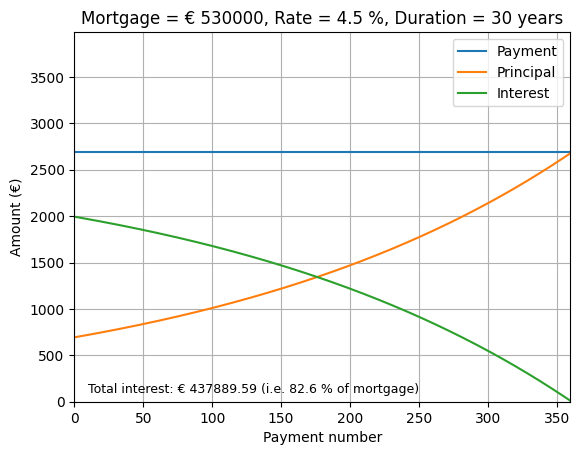

In [11]:
make_plot(df_annuity)

<Figure size 2000x1400 with 0 Axes>

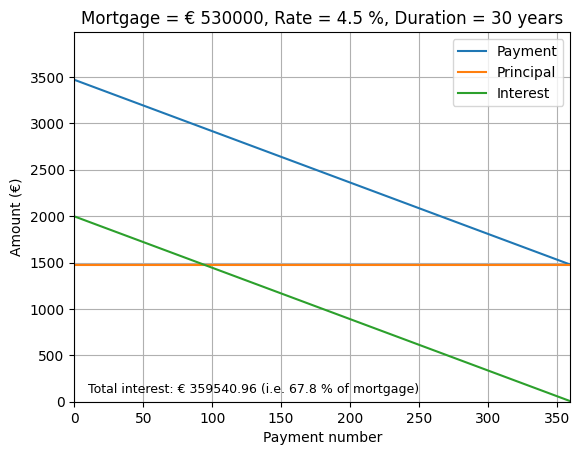

In [12]:
make_plot(df_linear)